# 3. Создание нейронной сети при помощи пакета `torch`. Dataset и Dataloader.

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt

## 1. Автоматическое дифференцирование в `torch`

1.1 Воспользовавшись классами `Neuron` и `MSELoss` из задачи 2.4.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать стохастический градиетный спуск.

In [2]:
from sklearn.datasets import make_regression

X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [3]:
class Neuron:
    def __init__(self, input):
        self.input = input

        self.weights = torch.randn(self.input, requires_grad=True)
        self.bias = torch.randn(1, requires_grad=True)

    def forward(self, inputs):
        return torch.sum(self.weights * inputs) + self.bias


class MSELoss:
    def forward(self, y_pred, y_true):
        return (y_pred - y_true) ** 2


In [4]:
torch.manual_seed(42)

neuron = Neuron(X.size(1))
mse = MSELoss()

lr = 0.1
epochs = 15
for _ in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        y_pred = neuron.forward(x)

        loss = mse.forward(y_pred, y_true)
        loss.backward()

        with torch.no_grad():
            neuron.weights -= lr * neuron.weights.grad
            neuron.bias -= lr * neuron.bias.grad

        neuron.weights.grad.zero_()
        neuron.bias.grad.zero_()

neuron.weights, coef

(tensor([49.2238, 90.9107, 24.3537, 85.5429], requires_grad=True),
 array([49.22376139, 90.91073638, 24.35368966, 85.54286417]))

1.2 Воспользовавшись классами `Linear` и `MSELoss` из задачи 2.1.4 и 2.3.1, `ReLU` из 2.2.1 и автоматическим дифференцированием, которое предоставляет `torch`, решить задачу регрессии. Для оптимизации использовать пакетный градиентный спуск. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [5]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [6]:
class Linear:
    def __init__(self, input, neurons):
        self.input = input

        self.weights = torch.randn(neurons, input, requires_grad=True)
        self.biases = torch.randn(neurons, requires_grad=True)

    def forward(self, inputs):
        return torch.matmul(inputs, self.weights.T) + self.biases



class MSELoss:
    def forward(self, y_pred, y_true):
        return ((y_true - y_pred) ** 2).mean()

    def backward(self, y_pred, y_true):
        self.dx = 2 * (y_pred - y_true) / y_pred.size(0)
        return self.dx


class ReLU:
    def forward(self, inputs):
        return torch.maximum(inputs, torch.tensor(0))


In [7]:
torch.manual_seed(42)

l1 = Linear(X.size(1), 100)
relu = ReLU()
l2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
epochs = 1000

losses = torch.empty(epochs)
for epoch in range(epochs):
    y_pred = l2.forward(relu.forward(l1.forward(X)))

    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    with torch.no_grad():
        l1.weights -= lr * l1.weights.grad
        l1.biases -= lr * l1.biases.grad
        l2.weights -= lr * l2.weights.grad
        l2.biases -= lr * l2.biases.grad

    l1.weights.grad.zero_()
    l1.biases.grad.zero_()
    l2.weights.grad.zero_()
    l2.biases.grad.zero_()

predicts = l2.forward(relu.forward(l1.forward(X)))

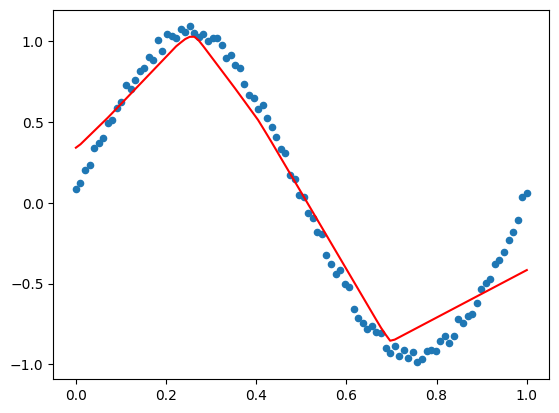

In [8]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=20)
ax.plot(X, predicts.detach(), c='r')
plt.show()

## 2. Алгоритмы оптимизации в `torch.optim`

In [10]:
import torch.optim as optim

2.1 Решить задачу 1.1, воспользовавшись оптимизатором `optim.SDG` для применения стохастического градиентого спуска

In [10]:
X, y, coef = make_regression(n_features=4, n_informative=4, coef=True, bias=0.5)
X = torch.from_numpy(X).to(dtype=torch.float32)
y = torch.from_numpy(y).to(dtype=torch.float32)

In [11]:
class MSELoss:
    def forward(self, y_pred, y_true):
        return ((y_true - y_pred) ** 2).mean()

    def backward(self, y_pred, y_true):
        self.dx = 2 * (y_pred - y_true)
        return self.dx
        

In [12]:
torch.manual_seed(42)

neuron = Neuron(X.size(1))
mse = MSELoss()

lr = 0.1
optimizer = optim.SGD([neuron.weights, neuron.bias], lr=lr)

epochs = 10
for epoch in range(epochs):
    for i, (x, y_true) in enumerate(zip(X, y)):
        optimizer.zero_grad()

        y_pred = neuron.forward(x)
        loss = mse.forward(y_pred, y_true)
        loss.backward()

        optimizer.step()

neuron.weights, coef

(tensor([51.7509,  9.1101, 35.3447, 22.6725], requires_grad=True),
 array([51.75094245,  9.11006892, 35.34466505, 22.67248239]))

2.2 Решить задачу 1.2, воспользовавшись оптимизатором `optim.Adam` для применения пакетного градиентого спуска. Вывести график функции потерь в зависимости от номера эпохи. Вывести на одном графике исходные данные и предсказанные значения.

In [13]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size())

In [14]:
class MSELoss:
    def forward(self, y_pred, y_true):
        return ((y_true - y_pred) ** 2).mean()

    def backward(self, y_pred, y_true):
        self.dx = 2 * (y_pred - y_true) / y_pred.size(0)
        return self.dx

In [15]:
torch.manual_seed(42)

l1 = Linear(X.size(1), 100)
relu = ReLU()
l2 = Linear(100, y.size(1))
mse = MSELoss()

lr = 0.01
optimizer = optim.Adam([l1.weights, l1.biases, l2.weights, l2.biases], lr=lr)

epochs = 1000
losses = torch.empty(epochs)
for epoch in range(epochs):
    optimizer.zero_grad()

    y_pred = l2.forward(relu.forward(l1.forward(X)))
    loss = mse.forward(y_pred, y)
    loss.backward()
    losses[epoch] = loss

    optimizer.step()

predicts = l2.forward(relu.forward(l1.forward(X)))

In [ ]:
_, ax = plt.subplots(1)

ax.scatter(X, y, s=20)
ax.plot(X, predicts.detach(), c='r')
plt.show()

## 3. Построение сетей при помощи `torch.nn`

In [11]:
import torch.nn as nn

3.1 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде класса - наследника `nn.Module`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [7]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [13]:
class Net(nn.Module):
    def __init__(self, neurons):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(1, neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

neuron = Net(3)
optimizer = optim.Adam(neuron.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = neuron.forward(X)
    loss_val = loss(y_pred, y)

    loss_val.backward()

    optimizer.step()
    
    if epoch % 100 == 0: print(f"Epoch {epoch} loss: {loss_val}")

Epoch 0 loss: 1.1138478517532349
Epoch 100 loss: 0.4571310877799988
Epoch 200 loss: 0.33081236481666565
Epoch 300 loss: 0.19699892401695251
Epoch 400 loss: 0.17748858034610748
Epoch 500 loss: 0.17214149236679077
Epoch 600 loss: 0.16619540750980377
Epoch 700 loss: 0.1593126654624939
Epoch 800 loss: 0.15172366797924042
Epoch 900 loss: 0.14370009303092957


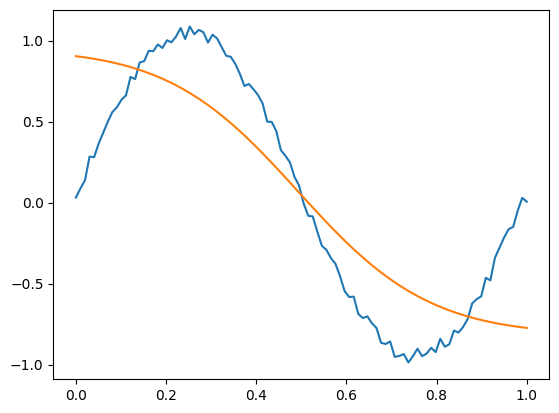

In [18]:
with torch.no_grad():
  plt.plot(X, y)
  plt.plot(X, neuron(X))

3.2 Решить задачу регрессии, соблюдая следующие условия:

1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [19]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

In [20]:
X = torch.linspace(0, 1, 100).view(-1, 1)
y = torch.sin(2 * np.pi * X) + 0.1 * torch.rand(X.size()) 

layers = [
    torch.nn.Linear(1, 5),
    torch.nn.Sigmoid(),
    torch.nn.Linear(5, 1)
]
model = torch.nn.Sequential(*layers)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

for epoch in range(1000):
    optimizer.zero_grad()

    y_pred = model.forward(X)
    loss_val = loss(y_pred, y)

    loss_val.backward()

    optimizer.step()
    
    if epoch % 100 == 0: print(f"Epoch {epoch} loss: {loss_val}")

Epoch 0 loss: 0.569923460483551
Epoch 100 loss: 0.3521806299686432
Epoch 200 loss: 0.18630947172641754
Epoch 300 loss: 0.1809440553188324
Epoch 400 loss: 0.17152711749076843
Epoch 500 loss: 0.15601742267608643
Epoch 600 loss: 0.13482309877872467
Epoch 700 loss: 0.11470187455415726
Epoch 800 loss: 0.08804763108491898
Epoch 900 loss: 0.057019203901290894


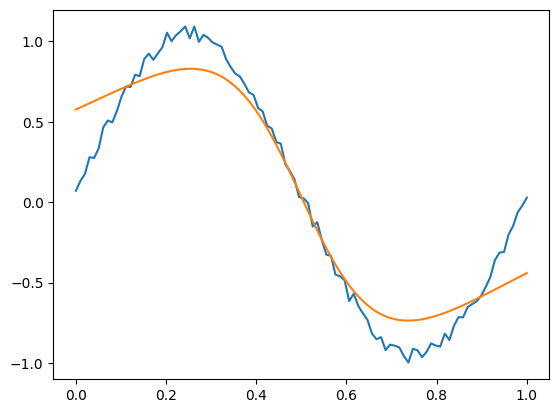

In [21]:
with torch.no_grad():
  plt.plot(X, y)
  plt.plot(X, model(X))

3.3 Решить задачу классификации. Датасет: Breast Cancer Wisconsin
1. Оформить нейронную сеть в виде объекта `nn.Sequential`
2. При создании сети использовать готовые блоки из `torch.nn`: слои, функции активации, функции потерь и т.д.
3. Для оптимизации использовать любой алгоритм оптимизации из `torch.optim` 

In [22]:
from sklearn import datasets

dataset = datasets.load_breast_cancer()

X = torch.from_numpy(dataset.data).to(torch.float32)
y = torch.from_numpy(dataset.target).to(torch.float32).view(-1, 1)

print(dataset.DESCR.split(':Summary Statistics:')[0].strip())

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi

In [23]:
torch.manual_seed(42)

net = nn.Sequential(
    nn.Linear(X.size(1), 50),
    nn.ReLU(),
    nn.Linear(50, y.size(1)),
    nn.Sigmoid(),
)
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.005)

epochs = 1000
for epoch in range(epochs + 1):
    optimizer.zero_grad()

    y_pred = net(X)
    loss = criterion(y_pred, y)
    loss.backward()

    optimizer.step()

    if epoch % 100 == 0: print(f"Epoch {epoch} loss: {loss_val}")


Epoch 0 loss: 0.03465729206800461
Epoch 100 loss: 0.03465729206800461
Epoch 200 loss: 0.03465729206800461
Epoch 300 loss: 0.03465729206800461
Epoch 400 loss: 0.03465729206800461
Epoch 500 loss: 0.03465729206800461
Epoch 600 loss: 0.03465729206800461
Epoch 700 loss: 0.03465729206800461
Epoch 800 loss: 0.03465729206800461
Epoch 900 loss: 0.03465729206800461
Epoch 1000 loss: 0.03465729206800461


## 4. Datasets and dataloaders

In [24]:
from torch.utils.data import Dataset, DataLoader

4.1 Создать датасет, поставляющий данные из задачи 1.2. 

Создать `DataLoader` на основе этого датасета и проверить работоспособность.

Воспользовавшись результатами 3.1 (или 3.2) обучите модель, пользуясь мини-пакетным градиентным спуском с размером пакета (`batch_size`) = 10

In [25]:
class SinDataset(Dataset):
    def __init__(self):
        self.X = torch.linspace(0, 1, 100).view(-1, 1)
        self.y = torch.sin(2 * np.pi * self.X) + 0.1 * \
            torch.rand(self.X.size())

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


class SineNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(SineNet, self).__init__()
        self.fc1 = torch.nn.Linear(1, n_hidden_neurons)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x


neuron = SineNet(3)
optimizer = optim.Adam(neuron.parameters(), lr=0.01)
loss = torch.nn.MSELoss()
dataloader = DataLoader(SinDataset(), batch_size=10)

for epoch in range(1000):
    X_new, y_new = next(iter(dataloader))
    optimizer.zero_grad()

    y_pred = neuron.forward(X_new)
    loss_val = loss(y_pred, y_new)

    loss_val.backward()

    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} loss: {loss_val}")


Epoch 0 loss: 0.03061779960989952
Epoch 100 loss: 0.02779426798224449
Epoch 200 loss: 0.014549726620316505
Epoch 300 loss: 0.0018174577271565795
Epoch 400 loss: 0.0010373902041465044
Epoch 500 loss: 0.0010347462957724929
Epoch 600 loss: 0.0010332404635846615
Epoch 700 loss: 0.001031807973049581
Epoch 800 loss: 0.0010301483562216163
Epoch 900 loss: 0.0010287337936460972


4.2 Предсказание цен алмазов

4.2.1 Создайте датасет на основе файла diamonds.csv. 

1. Удалите все нечисловые столбцы
2. Целевой столбец (`y`) - `price`
3. Преобразуйте данные в тензоры корректных размеров

4.2.2 Разбейте датасет на обучающий и тестовый датасет при помощи `torch.utils.data.random_split`.

4.2.3 Обучите модель для предсказания цен при помощи мини-пакетного градиентного спуска (`batch_size = 256`). 

4.2.4 Выведите график функции потерь в зависимости от номера эпохи (значение потерь для эпохи рассчитывайте как среднее значение ошибок на каждом батче). Проверьте качество модели на тестовой выборке. 


In [30]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader


class DiamondsDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.data = pd.read_csv(data, index_col=[0])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        self.X = torch.FloatTensor(self.data.select_dtypes(['number']).values)
        self.y = torch.FloatTensor(self.data['price'].values)
        return self.X[idx], self.y[idx]


dataset = DiamondsDataset('diamonds.csv')

train, test = torch.utils.data.random_split(
    dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])

diamonds_dataloader_train = DataLoader(train, batch_size=256)
diamonds_dataloader_test = DataLoader(test, batch_size=256)


In [34]:
class DiamondsNet(nn.Module):
    def __init__(self, neurons, n_features):
        super(DiamondsNet, self).__init__()
        self.fc1 = torch.nn.Linear(neurons, n_features)
        self.act1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_features, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        return x

neuron = DiamondsNet(7, 49)
optimizer = torch.optim.SGD(neuron.parameters(), lr=0.025)
loss = torch.nn.MSELoss()

loss_vals = []
for epoch in range(20):
    X_new, y_new = next(iter(diamonds_dataloader_train))
    optimizer.zero_grad()

    y_pred = neuron.forward(X_new)
    loss_val = loss(y_pred, y_new)
    loss_vals.append(loss_val)

    loss_val.backward()

    optimizer.step()
    
    print(f"Epoch {epoch} loss: {loss_val}")

/Users/user/GitHub/FA19/Course/ML/venv/lib/python3.9/site-packages/torch/nn/modules/loss.py:530: UserWarning: Using a target size (torch.Size([256])) that is different to the input size (torch.Size([256, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 0 loss: 29192700.0
Epoch 1 loss: 17448584.0
Epoch 2 loss: 15634954.0
Epoch 3 loss: 14572235.0
Epoch 4 loss: 14385574.0
Epoch 5 loss: 14355709.0
Epoch 6 loss: 14350931.0
Epoch 7 loss: 14350165.0
Epoch 8 loss: 14350042.0
Epoch 9 loss: 14350024.0
Epoch 10 loss: 14350021.0
Epoch 11 loss: 14350021.0
Epoch 12 loss: 14350020.0
Epoch 13 loss: 14350022.0
Epoch 14 loss: 14350021.0
Epoch 15 loss: 14350020.0
Epoch 16 loss: 14350020.0
Epoch 17 loss: 14350019.0
Epoch 18 loss: 14350019.0
Epoch 19 loss: 14350020.0


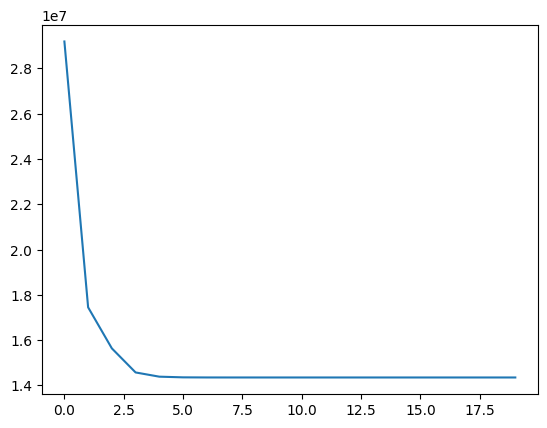

In [35]:
import matplotlib.pyplot as plt

with torch.no_grad():
  plt.plot(loss_vals)

4.3 Модифицируйте метод `__init__` датасета из 4.2 таким образом, чтобы он мог принимать параметр `transform: callable`. Реализуйте класс `DropColsTransform` для удаления нечисловых данных из массива. Реализуйте класс `ToTensorTransorm` для трансформации массива в тензор.

In [36]:
class DiamondsDataset(Dataset):
  def __init__(self, data, transform=None):
    self.data = pd.read_csv(data, index_col = [0])
    self.transform = transform

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    X = self.data.drop('price', axis=1)
    y = self.data['price']
    sample = X.iloc[idx], y.iloc[idx]
    if self.transform:
      sample = self.transform(sample)
    return sample

In [37]:
class DropColsTransform:
  def __init__(self, drop):
    self.drop = drop
  
  def __call__(self, sample):
    X, y = sample
    X = X.drop(X.index[self.drop], axis=0)
    return X, y

In [38]:
class ToTensorTransform:
  def __call__(self, sample):
    X, y = sample
    X = torch.FloatTensor(X.astype('float64').values)
    y = torch.FloatTensor([y])
    return X, y

In [39]:
from torchvision import transforms

drop = DropColsTransform(drop=[1, 2, 3])
to_tensor = ToTensorTransform()
dataset = DiamondsDataset('diamonds.csv', transform=transforms.Compose([drop, to_tensor]))

In [41]:
train, test = torch.utils.data.random_split(dataset, [int(len(dataset)*0.8), int(len(dataset)*0.2)])

diamonds_dataloader_train = DataLoader(train, batch_size=256)
diamonds_dataloader_test = DataLoader(test, batch_size=256)

In [42]:
class DiamondsNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons, n_features):
        super(DiamondsNet, self).__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Linear(n_features, n_hidden_neurons), 
            torch.nn.Sigmoid(), 
            torch.nn.Linear(n_hidden_neurons,n_hidden_neurons),
            torch.nn.Sigmoid(),
            torch.nn.Linear(n_hidden_neurons,n_hidden_neurons*2),
            torch.nn.Sigmoid(),
            torch.nn.Linear(n_hidden_neurons*2,1)
        )

    def forward(self, x):
        x = self.net(x)
        return x

neuron = DiamondsNet(16, 6)
optimizer = torch.optim.SGD(neuron.parameters(), lr=0.01)
loss = torch.nn.MSELoss()

loss_vals = []
for epoch in range(20):
    X_new, y_new = next(iter(diamonds_dataloader_train))
    optimizer.zero_grad()

    y_pred = neuron.forward(X_new)
    loss_val = loss(y_pred, y_new)
    loss_vals.append(loss_val)

    loss_val.backward()

    optimizer.step()
    
    print(f"Epoch {epoch} loss: {loss_val}")

Epoch 0 loss: 23495134.0
Epoch 1 loss: 20797674.0
Epoch 2 loss: 15253458.0
Epoch 3 loss: 12033299.0
Epoch 4 loss: 11656595.0
Epoch 5 loss: 11613046.0
Epoch 6 loss: 11608012.0
Epoch 7 loss: 11607431.0
Epoch 8 loss: 11607361.0
Epoch 9 loss: 11607355.0
Epoch 10 loss: 11607354.0
Epoch 11 loss: 11607354.0
Epoch 12 loss: 11607353.0
Epoch 13 loss: 11607354.0
Epoch 14 loss: 11607353.0
Epoch 15 loss: 11607355.0
Epoch 16 loss: 11607355.0
Epoch 17 loss: 11607354.0
Epoch 18 loss: 11607354.0
Epoch 19 loss: 11607354.0


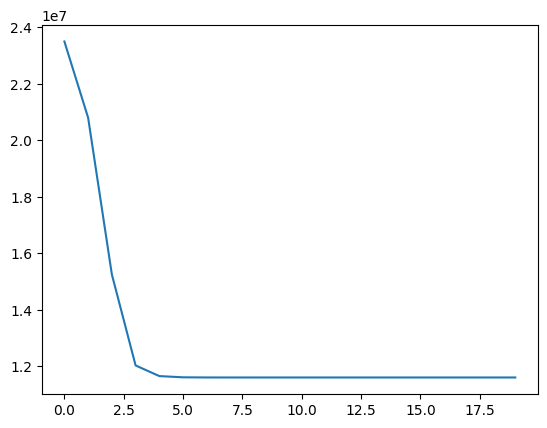

In [43]:
with torch.no_grad():
  plt.plot(loss_vals)